In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

In [2]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
from imblearn.over_sampling import SMOTE

In [3]:
z1=zipfile.ZipFile('train.csv.zip')
train=pd.read_csv(z1.open(z1.namelist()[0]),low_memory=False)

In [4]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
train['TARGET'].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

# Pre-processing

In [6]:
same_columns=[]
columns=train.columns
for i,column in enumerate(columns,1):
    v=train[column].values
    if v.std()==0:
        same_columns.append(column)
    for j in range(i+1,len(columns)):
        if np.array_equal(v,train[columns[j]].values):
            same_columns.append(columns[j])
print(len(same_columns),len(set(same_columns)))

600 50


In [7]:
train=train.drop(same_columns,axis=1)
print(train.shape)

(76020, 321)


# Divide into train and validation

In [15]:
minmax=StandardScaler()
train_data=train[train.columns[1:-1]]
train_data=minmax.fit_transform(train_data)
train_data=pd.concat([train['ID'],pd.DataFrame(train_data,columns=train.columns[1:-1]),train['TARGET']],axis=1)

val_data=pd.concat([train_data[train['TARGET']==0][:500][train.columns[1:-1]],train_data[train['TARGET']==1][:500][train.columns[1:-1]]],axis=0).values
val_y=np.r_[np.zeros((500,1)),np.ones((500,1))].reshape((1000,))

train_data=pd.concat([train_data[train['TARGET']==0][500:][train.columns[1:-1]],train_data[train['TARGET']==1][500:][train.columns[1:-1]]],axis=0).values
target=np.r_[train[train['TARGET']==0]['TARGET'][500:],train[train['TARGET']==1]['TARGET'][500:]].reshape(-1,)

# Over-Sampling

In [16]:
#normal random forest
rf=RandomForestClassifier()
rf.fit(train_data,target)
print('normal rf')
roc_auc_rf = roc_auc_score(val_y,rf.predict_proba(val_data)[:,1])
print(roc_auc_score(target,rf.predict_proba(train_data)[:,1]),roc_auc_rf)
fpr_rf, tpr_rf, _ = roc_curve(val_y,rf.predict_proba(val_data)[:,1])

#normal random forest with class weight
rf=RandomForestClassifier(class_weight='balanced')
rf.fit(train_data,target)
print('rf with class weight')
roc_auc_rf_cw = roc_auc_score(val_y,rf.predict_proba(val_data)[:,1])
print(roc_auc_score(target,rf.predict_proba(train_data)[:,1]),roc_auc_rf_cw)
fpr_rf_cw, tpr_rf_cw, _ = roc_curve(val_y,rf.predict_proba(val_data)[:,1])

#smote
rf=RandomForestClassifier()
smote=SMOTE(ratio='auto',kind='regular')
train_data_smote,target_smote=smote.fit_sample(train_data,target)
print(train_data_smote.shape)

rf.fit(train_data_smote,target_smote)
prediction1=rf.predict(train_data_smote)
prediction2=rf.predict(val_data)
print('smote with normal rf')
roc_auc_rf_smote = roc_auc_score(val_y,rf.predict_proba(val_data)[:,1])
print(roc_auc_score(target_smote,rf.predict_proba(train_data_smote)[:,1]),roc_auc_rf_smote)
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(val_y,rf.predict_proba(val_data)[:,1])


normal rf
0.9962560835775649 0.667686
rf with class weight
0.9899942261110432 0.6764060000000001
(145024, 319)
smote with normal rf
0.9988289040429208 0.727728


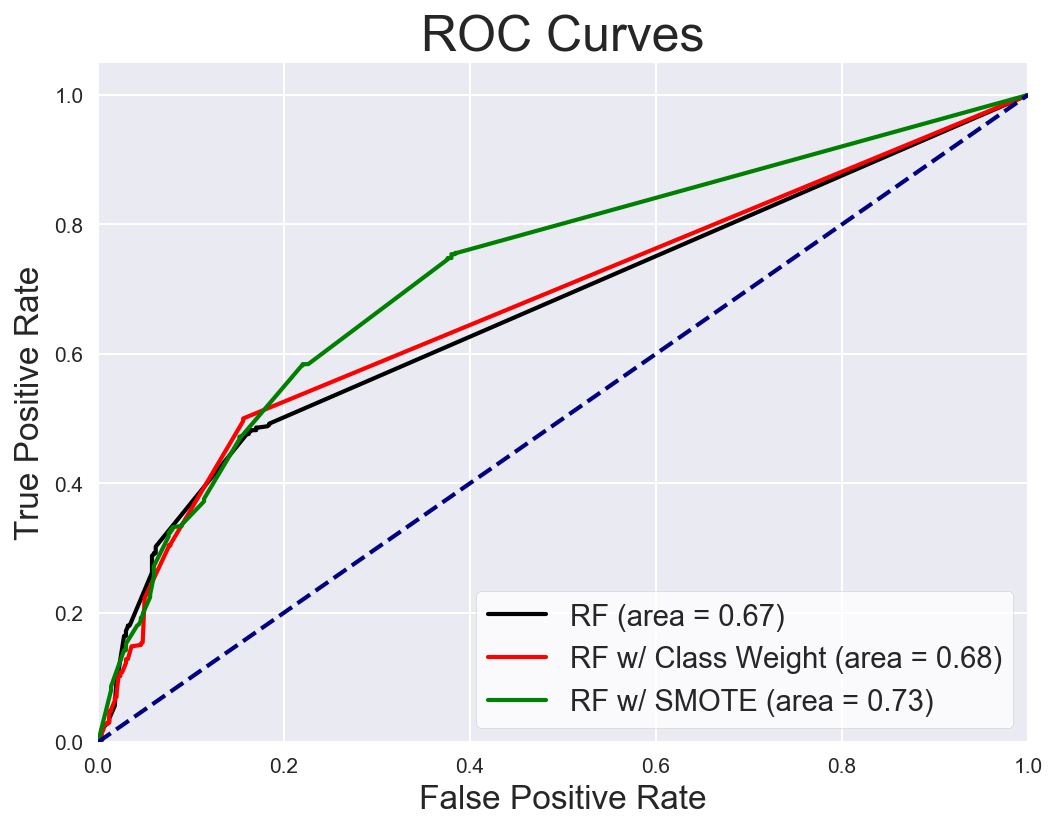

In [21]:
plt.figure(figsize=(8,6), dpi=150)
plt.plot(fpr_rf, tpr_rf, color='black',
         lw=2, label='RF (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_rf_cw, tpr_rf_cw, color='red',
         lw=2, label='RF w/ Class Weight (area = %0.2f)' % roc_auc_rf_cw)
plt.plot(fpr_rf_smote, tpr_rf_smote, color='green',
         lw=2, label='RF w/ SMOTE (area = %0.2f)' % roc_auc_rf_smote)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves', fontsize=24)
plt.legend(loc="lower right", frameon=True, facecolor='white', fontsize=14)
plt.show()

# PCA

(76020, 2)


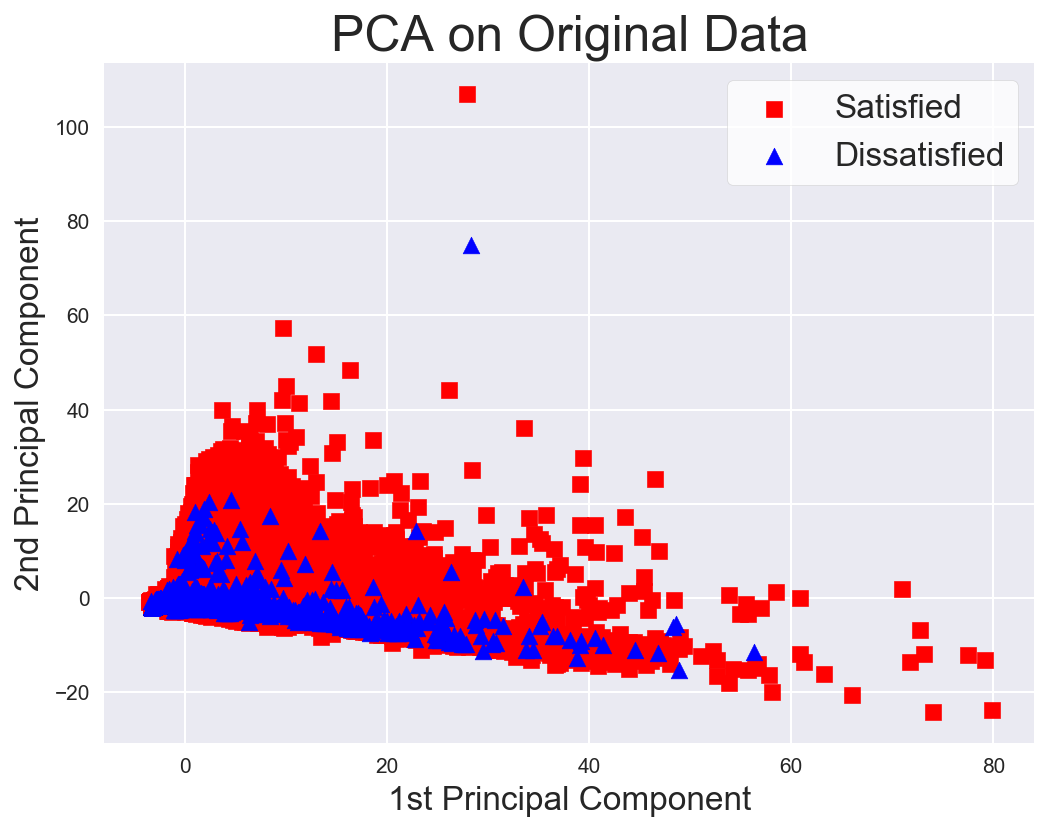

In [9]:
k=2
minmax=StandardScaler()
train_data=train[train.columns[1:-1]].values
train_data=minmax.fit_transform(train_data)
pca=PCA(n_components=k)
points_pca=pca.fit_transform(train_data)
print(points_pca.shape)
plt.figure(figsize=(8,6),dpi=150)
plt.scatter(points_pca[train['TARGET'].values==0,0],points_pca[train['TARGET'].values==0,1],label='Satisfied',c='r',marker='s',s=64)
plt.scatter(points_pca[train['TARGET'].values==1,0],points_pca[train['TARGET'].values==1,1],label='Dissatisfied',c='b',marker='^',s=64)
plt.title('PCA on Original Data', fontsize=24)
plt.xlabel('1st Principal Component', fontsize=16)
plt.ylabel('2nd Principal Component', fontsize=16)
plt.legend(fontsize=16, frameon=True, facecolor='white')

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(points_pca)

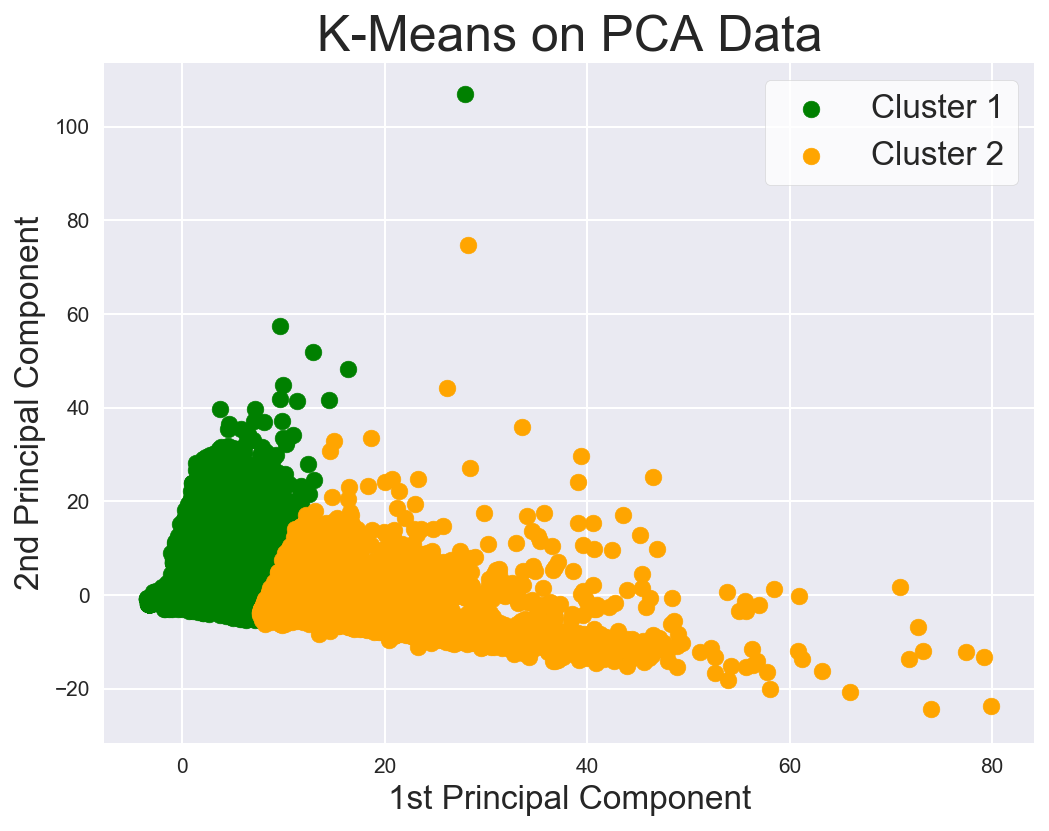

In [12]:
plt.figure(figsize=(8,6),dpi=150)
plt.scatter(points_pca[kmeans.labels_==0,0],points_pca[kmeans.labels_==0,1],label='Cluster 1',c='green',s=64)
plt.scatter(points_pca[kmeans.labels_==1,0],points_pca[kmeans.labels_==1,1],label='Cluster 2',c='orange',s=64)
plt.title('K-Means on PCA Data', fontsize=24)
plt.xlabel('1st Principal Component', fontsize=16)
plt.ylabel('2nd Principal Component', fontsize=16)
plt.legend(fontsize=16, frameon=True, facecolor='white')

In [19]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.75, n_jobs=-1).fit(points_pca)

In [20]:
unique, counts = np.unique(dbs.labels_, return_counts=True)
print(dict(zip(unique, counts)))

{-1: 523, 0: 75267, 1: 37, 2: 7, 3: 7, 4: 6, 5: 16, 6: 6, 7: 8, 8: 6, 9: 8, 10: 15, 11: 13, 12: 8, 13: 8, 14: 7, 15: 5, 16: 5, 17: 15, 18: 10, 19: 7, 20: 8, 21: 5, 22: 5, 23: 5, 24: 4, 25: 5, 26: 4}


In [23]:
indices = [i for i in range(len(dbs.labels_)) if dbs.labels_[i] not in {0, 1}]
print(len(indices))

716


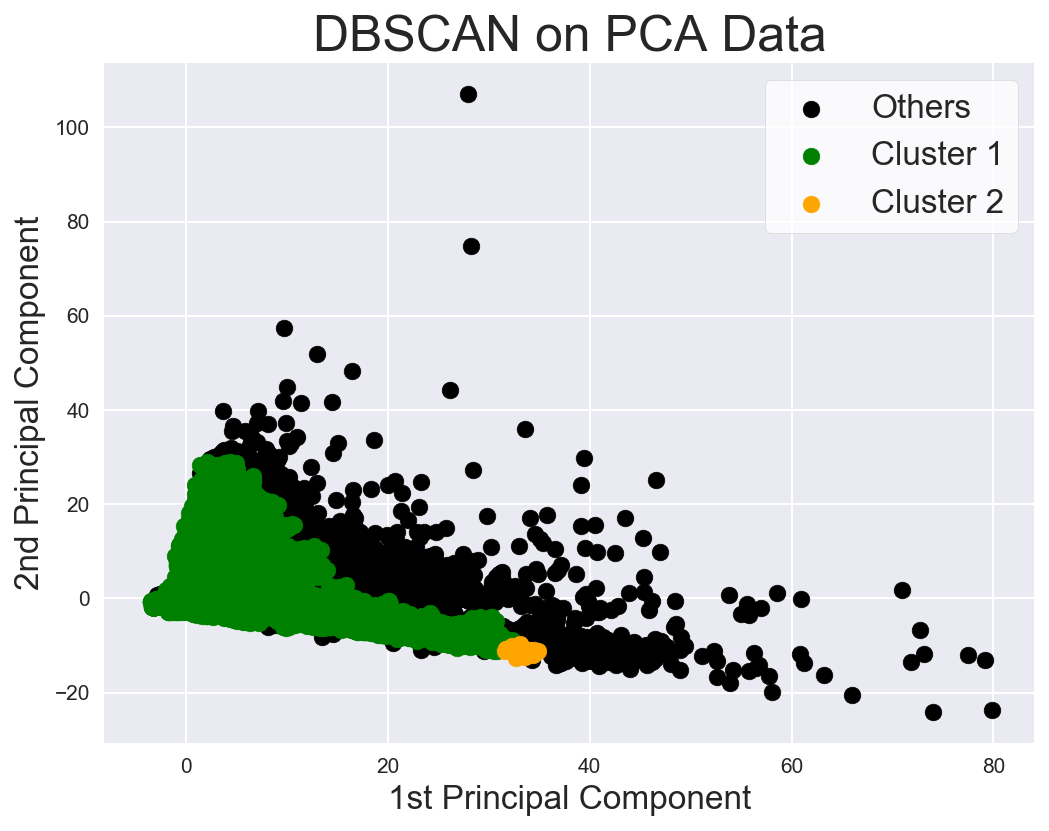

In [28]:
plt.figure(figsize=(8,6),dpi=150)
indices = [i for i in range(len(dbs.labels_)) if dbs.labels_[i] not in {0, 1}]
plt.scatter(points_pca[indices,0],points_pca[indices,1],label='Others',c='black',s=64)
plt.scatter(points_pca[dbs.labels_==0,0],points_pca[dbs.labels_==0,1],label='Cluster 1',c='green',s=64)
plt.scatter(points_pca[dbs.labels_==1,0],points_pca[dbs.labels_==1,1],label='Cluster 2',c='orange',s=64)
plt.title('DBSCAN on PCA Data', fontsize=24)
plt.xlabel('1st Principal Component', fontsize=16)
plt.ylabel('2nd Principal Component', fontsize=16)
plt.legend(fontsize=16, frameon=True, facecolor='white')

(145024, 2)


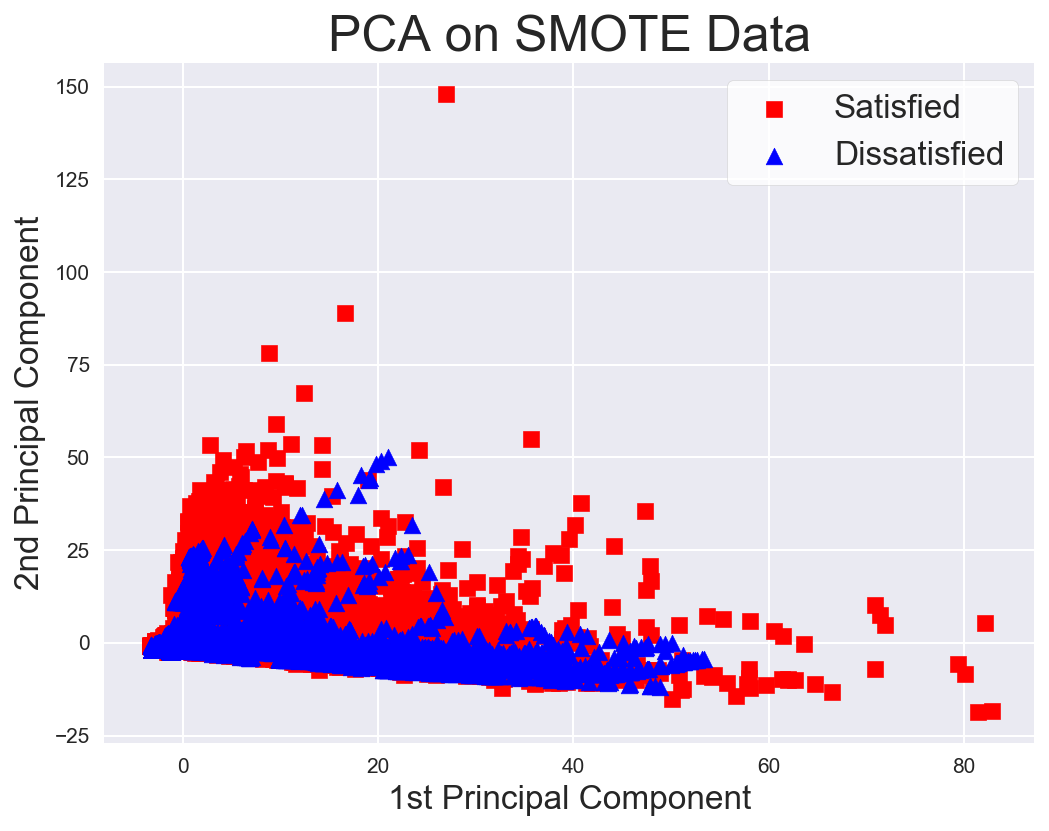

In [26]:
k=2
pca=PCA(n_components=k)
train_data_smote=minmax.fit_transform(train_data_smote)
points_pca_smote=pca.fit_transform(train_data_smote)
print(points_pca_smote.shape)

plt.figure(figsize=(8,6),dpi=150)
plt.scatter(points_pca_smote[target_smote==0,0],points_pca_smote[target_smote==0,1],label='Satisfied',c='r',marker='s',s=64)
plt.scatter(points_pca_smote[target_smote==1,0],points_pca_smote[target_smote==1,1],label='Dissatisfied',c='b',marker='^',s=64)
plt.title('PCA on SMOTE Data', fontsize=24)
plt.xlabel('1st Principal Component', fontsize=16)
plt.ylabel('2nd Principal Component', fontsize=16)
plt.legend(fontsize=16, frameon=True, facecolor='white')

In [29]:
abcd = [0,1,1,1,1,0,0,0,1]
2/np.bincount(abcd)

array([4, 5], dtype=int64)

# Under-sampling

In [22]:
train_0,train_1=train_data[target==0],train_data[target==1]

In [23]:
import time
rf_models=[]

val_predict_probas=[]
for i in range(50):
    np.random.shuffle(train_0)
    X_train=np.vstack([train_1,train_0[:2500]])
    y_train=np.r_[np.ones((2508,1)),np.zeros((2500,1))].reshape((5008,))
    rf=RandomForestClassifier()
    start=time.time()
    rf.fit(X_train,y_train)
    usetime=time.time()-start
    train_prediction=rf.predict_proba(X_train)
    print('用时:{},训练集roc:{}，测试集roc:{}'.format(usetime,roc_auc_score(y_train,train_prediction[:,1]),
                                         roc_auc_score(val_y,rf.predict_proba(val_data)[:,1])))

    val_predict_probas.append(rf.predict_proba(val_data)[:,1])
    rf_models.append(rf)
print('overall val roc {}'.format(roc_auc_score(val_y,np.mean(np.stack(val_predict_probas),axis=0))))

用时:0.07419991493225098,训练集roc:0.9954027910685805，测试集roc:0.801518
用时:0.07119131088256836,训练集roc:0.9955396331738438，测试集roc:0.786532
用时:0.0726938247680664,训练集roc:0.9952667464114833，测试集roc:0.792944
用时:0.07169079780578613,训练集roc:0.9948164274322169，测试集roc:0.787288
用时:0.07118964195251465,训练集roc:0.9955713716108453，测试集roc:0.78318
用时:0.07219219207763672,训练集roc:0.9946475279106858，测试集roc:0.7826080000000001
用时:0.07319498062133789,训练集roc:0.9954425837320575，测试集roc:0.794738
用时:0.07118892669677734,训练集roc:0.9951865231259969，测试集roc:0.786948
用时:0.07169222831726074,训练集roc:0.9952248006379585，测试集roc:0.7777960000000002
用时:0.0726931095123291,训练集roc:0.9954636363636363，测试集roc:0.786416
用时:0.06868290901184082,训练集roc:0.9955693779904307，测试集roc:0.791616
用时:0.06968522071838379,训练集roc:0.9953103668261563，测试集roc:0.77843
用时:0.07018733024597168,训练集roc:0.9960639553429027，测试集roc:0.7739020000000001
用时:0.07118892669677734,训练集roc:0.9952136363636364，测试集roc:0.7714179999999999
用时:0.07018661499023438,训练集roc:0.9953461722488038，测试集ro

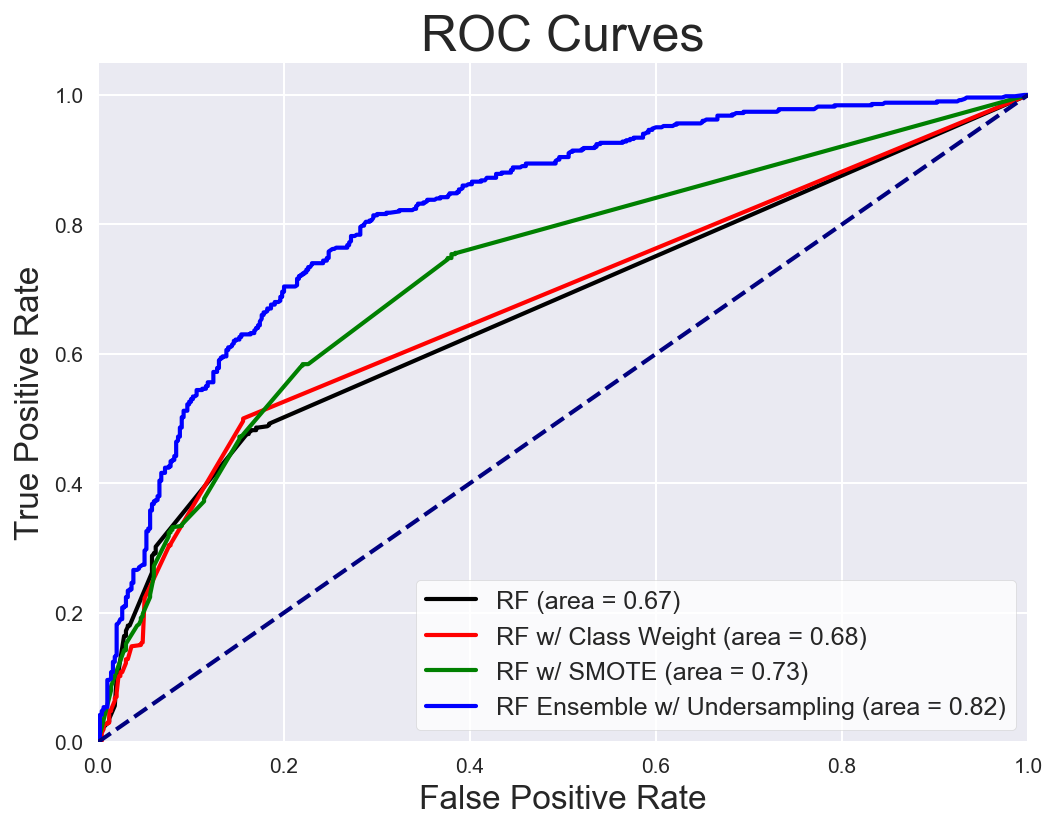

In [25]:
roc_auc_under = roc_auc_score(val_y,np.mean(np.stack(val_predict_probas),axis=0))
fpr_under, tpr_under, _ = roc_curve(val_y,np.mean(np.stack(val_predict_probas),axis=0))
plt.figure(figsize=(8,6), dpi=150)
plt.plot(fpr_rf, tpr_rf, color='black',
         lw=2, label='RF (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_rf_cw, tpr_rf_cw, color='red',
         lw=2, label='RF w/ Class Weight (area = %0.2f)' % roc_auc_rf_cw)
plt.plot(fpr_rf_smote, tpr_rf_smote, color='green',
         lw=2, label='RF w/ SMOTE (area = %0.2f)' % roc_auc_rf_smote)
plt.plot(fpr_under, tpr_under, color='blue',
         lw=2, label='RF Ensemble w/ Undersampling (area = %0.2f)' % roc_auc_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves', fontsize=24)
plt.legend(loc="lower right", frameon=True, facecolor='white', fontsize=12)
plt.show()

XGBOOST with fine-tuning

In [26]:
clf=xgb.XGBClassifier(missing=np.nan,n_estimators=400,max_depth=5,learning_rate=0.03,subsample=0.75,silent=1,colsample_bytree=0.75,objective= "binary:logistic")

In [27]:
clf.fit(train_data,target,eval_metric='auc',early_stopping_rounds=20,eval_set=[(train_data,target),(val_data,val_y)])

[0]	validation_0-auc:0.807261	validation_1-auc:0.80435
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.822679	validation_1-auc:0.808672
[2]	validation_0-auc:0.814388	validation_1-auc:0.791754
[3]	validation_0-auc:0.825633	validation_1-auc:0.804418
[4]	validation_0-auc:0.82709	validation_1-auc:0.804562
[5]	validation_0-auc:0.831293	validation_1-auc:0.80938
[6]	validation_0-auc:0.83446	validation_1-auc:0.813096
[7]	validation_0-auc:0.834068	validation_1-auc:0.813432
[8]	validation_0-auc:0.834675	validation_1-auc:0.815894
[9]	validation_0-auc:0.835511	validation_1-auc:0.817786
[10]	validation_0-auc:0.83593	validation_1-auc:0.81817
[11]	validation_0-auc:0.835605	validation_1-auc:0.81748
[12]	validation_0-auc:0.836537	validation_1-auc:0.819386
[13]	validation_0-auc:0.836947	validation_1-auc:0.819722
[14]	validation_0-auc:0.837253	validation_1-auc:0.819778
[15]	

[142]	validation_0-auc:0.866352	validation_1-auc:0.837952
[143]	validation_0-auc:0.866455	validation_1-auc:0.837888
[144]	validation_0-auc:0.866613	validation_1-auc:0.83767
[145]	validation_0-auc:0.866754	validation_1-auc:0.837906
[146]	validation_0-auc:0.866988	validation_1-auc:0.838466
[147]	validation_0-auc:0.867201	validation_1-auc:0.838678
[148]	validation_0-auc:0.86735	validation_1-auc:0.83867
[149]	validation_0-auc:0.867533	validation_1-auc:0.839098
[150]	validation_0-auc:0.867645	validation_1-auc:0.839404
[151]	validation_0-auc:0.867817	validation_1-auc:0.839488
[152]	validation_0-auc:0.868003	validation_1-auc:0.839802
[153]	validation_0-auc:0.868137	validation_1-auc:0.839786
[154]	validation_0-auc:0.868195	validation_1-auc:0.839754
[155]	validation_0-auc:0.868344	validation_1-auc:0.839938
[156]	validation_0-auc:0.868456	validation_1-auc:0.840022
[157]	validation_0-auc:0.868631	validation_1-auc:0.840198
[158]	validation_0-auc:0.868781	validation_1-auc:0.8403
[159]	validation_0-

[285]	validation_0-auc:0.882639	validation_1-auc:0.844166
[286]	validation_0-auc:0.882748	validation_1-auc:0.844358
[287]	validation_0-auc:0.8828	validation_1-auc:0.844334
[288]	validation_0-auc:0.882903	validation_1-auc:0.844374
[289]	validation_0-auc:0.882991	validation_1-auc:0.844346
[290]	validation_0-auc:0.883115	validation_1-auc:0.84427
[291]	validation_0-auc:0.883213	validation_1-auc:0.844166
[292]	validation_0-auc:0.883254	validation_1-auc:0.844114
[293]	validation_0-auc:0.883372	validation_1-auc:0.844118
[294]	validation_0-auc:0.883416	validation_1-auc:0.844102
[295]	validation_0-auc:0.883439	validation_1-auc:0.844098
[296]	validation_0-auc:0.883494	validation_1-auc:0.844198
[297]	validation_0-auc:0.883553	validation_1-auc:0.844178
[298]	validation_0-auc:0.883658	validation_1-auc:0.844124
[299]	validation_0-auc:0.88371	validation_1-auc:0.844144
[300]	validation_0-auc:0.883751	validation_1-auc:0.844116
[301]	validation_0-auc:0.883864	validation_1-auc:0.84396
[302]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=400, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.75)

In [28]:
print('训练集auc:{},val auc:{}'.format(roc_auc_score(target,clf.predict_proba(train_data)[:,1]),
                                              roc_auc_score(val_y,clf.predict_proba(val_data)[:,1])))

训练集auc:0.884556225022558,val auc:0.844168


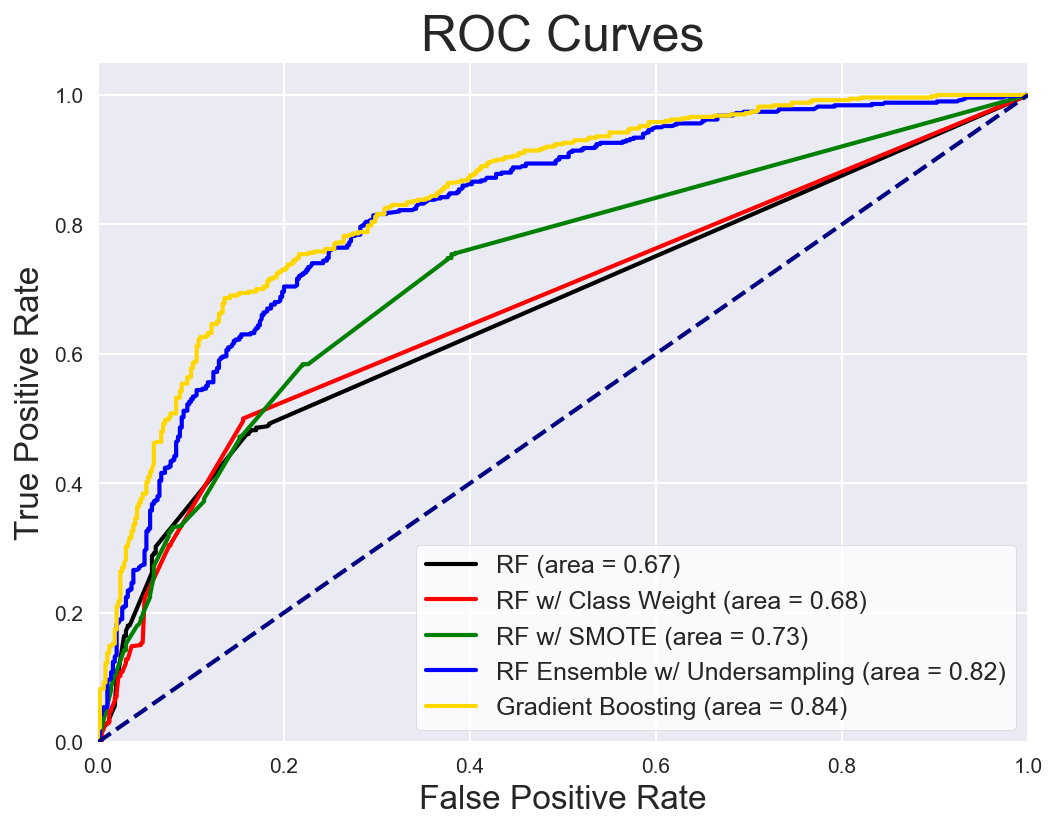

In [29]:
roc_auc_xgb = roc_auc_score(val_y,clf.predict_proba(val_data)[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(val_y,clf.predict_proba(val_data)[:,1])
plt.figure(figsize=(8,6), dpi=150)
plt.plot(fpr_rf, tpr_rf, color='black',
         lw=2, label='RF (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_rf_cw, tpr_rf_cw, color='red',
         lw=2, label='RF w/ Class Weight (area = %0.2f)' % roc_auc_rf_cw)
plt.plot(fpr_rf_smote, tpr_rf_smote, color='green',
         lw=2, label='RF w/ SMOTE (area = %0.2f)' % roc_auc_rf_smote)
plt.plot(fpr_under, tpr_under, color='blue',
         lw=2, label='RF Ensemble w/ Undersampling (area = %0.2f)' % roc_auc_under)
plt.plot(fpr_xgb, tpr_xgb, color='gold',
         lw=2, label='Gradient Boosting (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves', fontsize=24)
plt.legend(loc="lower right", frameon=True, facecolor='white', fontsize=12)
plt.show()